In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import requests
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS

from utils import plot_samples

sns.set_palette("Set2")

In [2]:
data = requests.get("https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv")
data = [float(d) for d in data.text.split()]

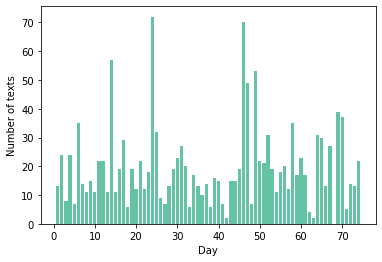

In [3]:
fig, ax = plt.subplots()

ax.bar(np.arange(len(data)) + 1, data)
ax.set_xlabel("Day")
ax.set_ylabel("Number of texts")

plt.show()

In [4]:
texts = torch.tensor(data)

In [5]:
def texts_model(texts):
    alpha = pyro.param("alpha", 1 / texts.mean())
    lambda_1 = pyro.sample("lambda_1", dist.Exponential(alpha))
    lambda_2 = pyro.sample("lambda_2", dist.Exponential(alpha))

    # We sample continuously to make inference about tau simpler
    tau = pyro.sample("tau", dist.Uniform(0, texts.shape[0]))

    lambdas = torch.ones(texts.shape[0]) * lambda_2
    lambdas[: torch.floor(tau).long()] = lambda_1

    pyro.sample("texts", dist.Poisson(lambdas), obs=texts)

In [6]:
nuts_kernel = NUTS(texts_model)

# Let's choose a low number of samples for testing
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)

mcmc.run(texts)

Sample: 100%|██████████| 1200/1200 [31:26,  1.57s/it, step size=2.84e-03, acc. prob=0.772]


In [7]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
mcmc_samples["tau"] = np.floor(mcmc_samples["tau"])

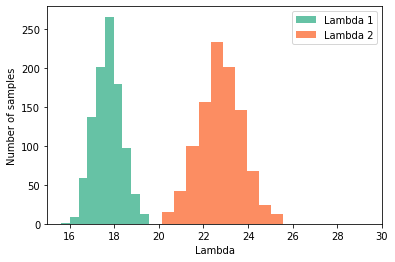

In [8]:
# Rate increases from about 18 to about 23 expected texts per day
fig, ax = plt.subplots()

ax.hist(mcmc_samples["lambda_1"], label="Lambda 1")
ax.hist(mcmc_samples["lambda_2"], label="Lambda 2")

ax.set_xlim(15, 30)
ax.set_xlabel("Lambda")
ax.set_ylabel("Number of samples")
ax.legend()

plt.show()

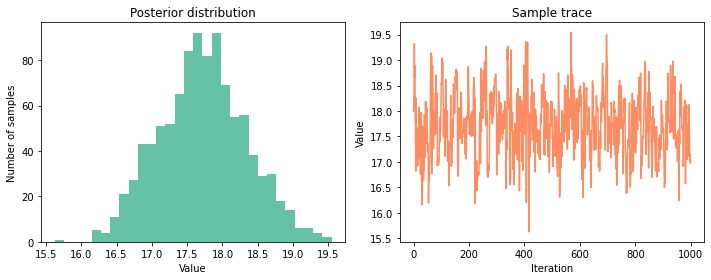

In [9]:
# When we inspect the trace we see that the chain has not fully converged
plot_samples(mcmc_samples["lambda_1"])

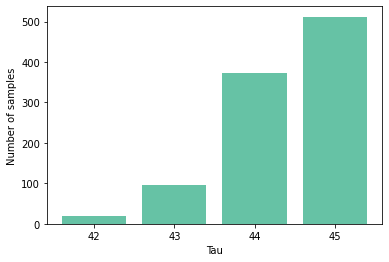

In [10]:
# Seems like the rate of texts changes somewhere between day 42 and 45
# Shifted by one compared to the original, see below why this makes sense
fig, ax = plt.subplots()

unique, counts = np.unique(mcmc_samples["tau"], return_counts=True)

ax.bar(unique, counts)

ax.set_xticks(unique)
ax.set_xlabel("Tau")
ax.set_ylabel("Number of samples")

plt.show()

In [11]:
n_samples = len(mcmc_samples["tau"])
n_days = len(data)

In [12]:
# We can also calculate the expected rate per day
days = np.tile(np.arange(n_days), (n_samples, 1))

idx = days < mcmc_samples["tau"].reshape((n_samples, 1))

rates = (
    idx * mcmc_samples["lambda_1"].reshape((n_samples, 1))
    + ~idx * mcmc_samples["lambda_2"].reshape((n_samples, 1))
)

expected_rates = rates.mean(axis=0)  # we average over all samples per day

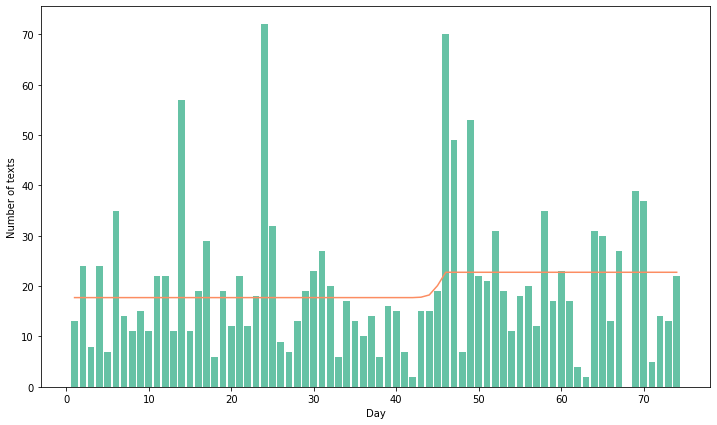

In [13]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(np.arange(len(data)) + 1, data, color=sns.color_palette()[0])
ax.plot(np.arange(len(data)) + 1, expected_rates, color=sns.color_palette()[1])

ax.set_xlabel("Day")
ax.set_ylabel("Number of texts")

plt.show()